

```
`# This is formatted as code`
```

# Connect to GDrive and set working directory
## !! Skip if you run in local !!
1. Add a shortcut for working directory('IDPCode') to your drive as depicted below:
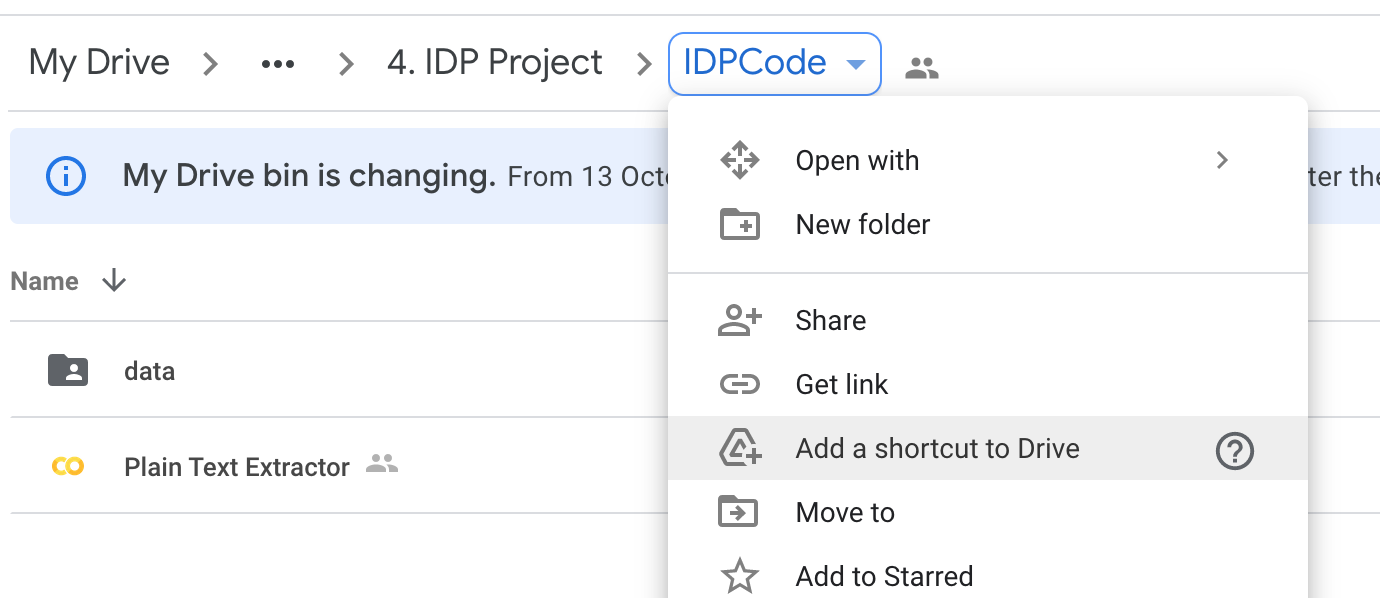
2. Run the command below to connect the GDrive:



In [ ]:
# https://github.com/njanakiev/folderstats
# https://janakiev.com/blog/python-filesystem-analysis/
# https://networkx.org/documentation/stable/
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My Drive/IDPCode/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1d2RlPHkcJvE2Q0NDVZjeNW8VcVz3h_WL/IDPCode


In [ ]:
!pip install ipython-autotime
!pip install pickle5
!pip install spacy
!pip install spacy_langdetect
!pip install textacy
!pip install pandarallel
!pip install pyLDAvis

In [ ]:
import pandas as pd
import numpy as np
import pickle5 as pickle
import pickle as normal_pickle
import gensim

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
# show execution time of cells
%load_ext autotime

# CHANGE PATH FOR THE DATASET FOLDER
DATA_DIRECTORY='data'


time: 216 µs (started: 2021-02-21 16:57:26 +00:00)


In [ ]:
REPLACED_WORDS_EXCEL = pd.read_excel(DATA_DIRECTORY+'/StopWords/removed_words.xlsx')
REPLACED_WORDS = REPLACED_WORDS_EXCEL[REPLACED_WORDS_EXCEL['Reasonable?']==True]
REPLACED_WORDS.head(10)
print(f'Number of words: {len(REPLACED_WORDS_EXCEL)}')
print(f'Number of approved words: {len(REPLACED_WORDS)}')
REPLACED_WORDS.head(10)
REPLACED_WORDS = REPLACED_WORDS['Removed Words'].values
print(REPLACED_WORDS)

Number of words: 289
Number of approved words: 76
['framework for the analysis' 'testingic auditing' 'review process'
 'journal accounting and public policy' 'the accounting review'
 'accounting forum' 'critical perspectives accointing'
 'accounting and business research'
 'accounting auditing accountability journal' 'doi' 'new york'
 'managementothing' 'winter' 'accounting and finance' 'copyright'
 'account public policy' 'accounting research and policy making'
 'november' 'accounting horizons' 'june' 'ybare' 'aos' 'fdi'
 'int tax public finance' 'european accounting review'
 'management accounting research' 'jel classification' 'the role big'
 'research managerial accounting learning' 'managerial auditing journal'
 'autumn' 'february' 'issnmanagement accounting research' 'peer reviews'
 'disclosuresnge' 'mcb university press' 'may' 'available online'
 'sarbanesoxley act' 'rev account stud' 'december' 'july' 'fall'
 'contemporary accounting research' 'march' 'january'
 'vale louis gol

In [ ]:
import en_core_web_sm
nlp = en_core_web_sm.load()
#https://pypi.org/project/spacy-langdetect/
from spacy_langdetect import LanguageDetector
nlp.add_pipe(LanguageDetector(), name="language_detector", last=True)

time: 1.45 s (started: 2021-02-21 16:57:26 +00:00)


In [ ]:
# Utility functions
def remove_dollar_sign(text):
  '''
  While drawing title count distribution, mathplotlib throws an error.
  Because some titles have dollar sign('$'). This method is used to clear the sign.
  '''
  
  text = str(text).replace('$', '\$')
  return text

import re
import string
import textacy
from textacy import preprocessing
def clean_text(text):
  '''
  Eliminates links, non alphanumerics, and punctuation.
  Returns lower case text.
  '''  
  
  # Convert to string
  text = str(text)
  # Remove non-ascii
  text = text.encode('ascii', 'ignore').decode('ascii')
  # Remove links
  text = re.sub('(?:(?:https?|ftp):\/\/)?[\w/\-?=%.]+\.[\w/\-?=%.]+', '', text)
  # Remove E-Mail addresses
  text = re.sub(r'\b[a-z]+@[a-z]+\b', r'', str(text))
  # Remove non-alphanumerics
  text = re.sub('\w*\d\w*', ' ', text)
  # Remove punctuation and lowercase
  text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text.lower())
  # Remove newline characters
  text = re.sub("\n", r' ', text)
  # Remove text in square brackets
  text = re.sub(r'\[.*?\]', '', text)
  # Remove words containing numbers
  text = re.sub(r'\w*\d\w*', '', text)
  # https://textacy.readthedocs.io/en/0.10.1/_modules/textacy/preprocessing/normalize.html
  text = textacy.preprocessing.normalize.normalize_whitespace(str(text))
  # replace words with less than 2 characters
  text = re.sub(r'\b[a-z]{1,2}\b', r'', str(text))
    
  return text

def replace_text(text, replacement_texts=REPLACED_WORDS):
  pattern = re.compile("|".join([re.escape(i) for i in replacement_texts]))
  text = pattern.sub(lambda m: '', str(text))
  return text

def lemmatizer(text, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):        
  sent = []
  doc = nlp(text)
#  for word in doc:
#    sent.append(word.lemma_)
  sent =  [token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]
    
  return " ".join(sent)

# Lemmatization, remove pronouns.
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        texts_out.append(lemmatizer(" ".join(sent), allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']))
    return texts_out

def remove_stopwords(text):
  clean_text = []
  for word in text.split(' '):
    if word not in stop_list and (len(word) > 2):
      clean_text.append(word)
  
  return ' '.join(clean_text)

def display_topics(model, feature_names, no_top_words, no_top_topics, topic_names=None):
  count = 0
  for ix, topic in enumerate(model.components_):
    if count == no_top_topics:
      break
    if not topic_names or not topic_names[ix]:
      print("\nTopic ", (ix + 1))
    else:
      print("\nTopic: '",topic_names[ix],"'")
    print(", ".join([feature_names[i] for i in topic.argsort()[:-no_top_words-1:-1]]))
    count += 1
    
def word_count(text):
    return sum([i.strip(string.punctuation).isalpha() for i in text.split()])
  
from IPython.core.display import display, HTML
def print_html(data):
  display(HTML('<div style="width: 90%">'+data+'</div>'))
  
  
def print_lemmatized(text, colorized_ignored=False, ignore_type='allowed'):
  allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']
  doc_lemma = nlp(text)
  lemms = []
  poses = []
  #colors = ['#f88f88','#DA553F','#045E5B','#731425','#F61E9E','#f44f44','#ff0','#0ff','#f0f']  
  import random
  r = lambda: random.randint(0,255)
  colors = ['#%02X%02X%02X' % (r(),r(),r()) for i in range(30)]

  for token in doc_lemma:
    if token.pos_ not in poses:
      poses.append(token.pos_)

  print(poses)
  for token in doc_lemma:
    if (ignore_type=='allowed' and token.pos_ not in allowed_postags) or (ignore_type=='stop_word' and token.is_stop):
      ignored_color = '#FF8983' if colorized_ignored else colors[poses.index(token.pos_)]
      
      lemms.append('<span style="color: #fff; padding: 0 10px; background-color: '+ignored_color+'"> '+token.lemma_+' </span>')
    else:
      lemms.append(token.lemma_)
      
  print_html('allowed_postags: '+' '.join(['<span style="color: #fff; padding: 0 10px; background-color: '+colors[allowed_postags.index(i)]+'"> '+i+' </span>' for i in allowed_postags]))
  print_html('available: '+' '.join(['<span style="color: #fff; padding: 0 10px; background-color: '+colors[poses.index(i)]+'"> '+i+' </span>' for i in poses]))
  print_html(' '.join(lemms))
  
import os
def get_file_name(file_path):
  f = os.path.basename(file_path)
  return f.replace('.pdf', '')

def run_in_parallel(dt, function, n_cores=8):
    df_n = np.array_split(df, n_cores)

    pool = Pool(n_cores)
    df = pd.concat(pool.map(func, df_n))
    pool.close()
    pool.join()
    return df
  
def remove_non_english_sent(text):
  doc = nlp(text)
  return ' '.join([sent.text for sent in doc.sents if sent._.language["language"] == 'en'])

def document_lang(text):
  doc = nlp(text)
  return doc._.language["language"]

def combine_authors(author_list):
  if isinstance(author_list, list):
    return ', '.join(author_list)

  return author_list

def journal_name(text):
  text = get_file_name(text)
  t = re.findall('([0-9]+)_([a-zA-Z]+)', text, re.IGNORECASE)
  return [i[1] for i in t][0]

from sklearn.metrics.pairwise import cosine_similarity

def produce_rec_top_n(top_vec, topic_array, doc_topic_df, norms, n=5):
    co_dists = compute_dists(top_vec, topic_array, norms)
    index_top_n = np.argpartition(co_dists, -n)[-n:]
    index_top_n = index_top_n[np.argsort(-co_dists[index_top_n])]
    return doc_topic_df.loc[index_top_n]
  
def compute_dists(top_vec, topic_array, norms):
    '''
    Returns cosine distances for top_vec compared to every article
    '''
    dots = np.matmul(topic_array, top_vec)
    input_norm = np.linalg.norm(top_vec)
    co_dists = dots / (input_norm * norms)
    return co_dists
  
def produce_rec(top_vec, topic_array, doc_topic_df, norms, rand = 15):
    '''
    Produces a recommendation based on cosine distance.
    rand controls magnitude of randomness.
    '''
#    top_vec = top_vec + np.random.rand(30,)/(np.linalg.norm(top_vec)) * rand
    co_dists = compute_dists(top_vec, topic_array, norms)
    return doc_topic_df.loc[np.argmax(co_dists)]

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

# Define function to predict topic for a given new question.
def predict_topic(text, lda_model, count_vectorizer, df_topic_keywords, nlp=nlp):
    global sent_to_words

    # Clean
    for i in range(len(text)):
      text[i] = clean_text(text[i])
      
    #
    for i in range(len(text)):
      text[i] = replace_text(text[i])
    for i in range(len(text)):
      text[i] = clean_text(text[i])
      
    # Remove stopwordstopic_array
    for i in range(len(text)):
      text[i] = remove_stopwords(text[i])
    
    # Clean with simple_preprocess
    mytext_2 = list(sent_to_words(text))

    # Lemmatize is skipped !!!
    # mytext_3_1 = []
    # for sent in mytext_2:
    #   mytext_3_1.append(" ".join(sent))
    # Lemmatize
    mytext_3 = lemmatization(mytext_2, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

    #print('Text after lemmatization ({} characters):'.format(len(mytext_3[0])))
    #print(mytext_3[0][0:100]+" ...")
    
    # stemming is skipped !!!
    #mytext_3_1 = []
    #for t in mytext_3:
    #  mytext_3_1.append(stem_text(t))
    
    # Vectorize transform
    mytext_4 = count_vectorizer.transform(mytext_3)
    
    #print('Count vectorizer of transformed text: {}'.format(mytext_4.shape))
    #print('Vectorized data {}'.format(data_vectorized.shape))
    #print('First 100 Feature names:')
    #print(count_vectorizer.get_feature_names()[:100])
    #print('')
    

    # LDA Transform
    topic_probability_scores = lda_model.transform(mytext_4)
    topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), :].values.tolist()
    return topic, topic_probability_scores
  

def accuracy_n(file_path, data, lda_model, count_vectorizer, df_topic_keywords, topic_array, doc_topic_df, norms, top_n=[1]):
  #print(file_path)
  topic, prob_scores = predict_topic([data], lda_model, count_vectorizer, df_topic_keywords)

  topic_columns = ['Topic '+str(i) for i in range(1, df_topic_keywords.shape[0]+1)]
  recs = produce_rec_top_n(prob_scores.flatten(), topic_array, doc_topic_df, norms, max(top_n))

  existence = []
  
  for n in top_n:    
    if recs['file_path'].head(n).str.contains(get_file_name(file_path)).any():
      existence.append(1)
    else:
      existence.append(0)

  return pd.Series(existence)


def show_topics(vectorizer, lda_model, n_words):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords
  
def label_theme(row):
    return "Topic " + str(row)

  
  


time: 1.56 s (started: 2021-02-21 16:57:27 +00:00)


In [ ]:
# USE dt3c INSTEAD
dt = pickle.load(open('en_cleaned_accounting_replaced_stop_words_lemmatized_all_pages_separetely.pkl', "rb"))# https://drive.google.com/file/d/11ZYfDF9XSXY5bHVhpEHeZXInnNIa9lot/view?usp=sharing

time: 2min 7s (started: 2021-02-21 17:02:22 +00:00)


In [ ]:
# USE dt3c INSTEAD
rt = pd.read_excel('DATA_RELEVANT.xlsx')

time: 9.06 s (started: 2021-02-21 16:59:37 +00:00)


In [ ]:
# Import
from pandarallel import pandarallel

# Initialization
pandarallel.initialize()

INFO: Pandarallel will run on 2 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
time: 52.2 ms (started: 2021-02-21 16:59:46 +00:00)


### 1.3.1 Find accounting related stop words

from https://sraf.nd.edu/textual-analysis/resources/

In [ ]:
stop_words_data1 = open(DATA_DIRECTORY + "/StopWords/StopWords_Auditor.txt", "r").read().lower().split()
stop_words_data2 = open(DATA_DIRECTORY + "/StopWords/StopWords_Currencies.txt", "r").read().lower().split()
stop_words_data3 = open(DATA_DIRECTORY + "/StopWords/StopWords_DatesandNumbers.txt").read().lower().split()
stop_words_data4 = open(DATA_DIRECTORY + "/StopWords/StopWords_Generic.txt").read().lower().split()
stop_words_data5 = open(DATA_DIRECTORY + "/StopWords/StopWords_GenericLong.txt").read().lower().split()
stop_words_data6 = open(DATA_DIRECTORY + "/StopWords/StopWords_Geographic.txt").read().lower().split()
stop_words_data7 = open(DATA_DIRECTORY + "/StopWords/StopWords_Names.txt").read().lower().split()

mallet_stop_words_en = open(DATA_DIRECTORY + "/StopWords/MALLET_en.txt", "r").read().lower().split()
mallet_stop_words_fr = open(DATA_DIRECTORY + "/StopWords/MALLET_fr.txt", "r").read().lower().split()

stop_words_data2 = list(filter(lambda a : a != "|", stop_words_data2))
stop_words_data3 = list(filter(lambda a : a != "|", stop_words_data3))
stop_words_data6 = list(filter(lambda a : a != "|", stop_words_data6))
stop_words_data7 = list(filter(lambda a : a != "|", stop_words_data7))

stop_words_data = stop_words_data1 + \
stop_words_data2 + \
stop_words_data3 + \
stop_words_data4 + \
stop_words_data5 + \
stop_words_data6 + \
stop_words_data7 + \
mallet_stop_words_en + \
mallet_stop_words_fr

print(f'{len(set(stop_words_data1))} => StopWords_Auditor.txt')
print(f'{len(set(stop_words_data2))} => StopWords_Currencies.txt')
print(f'{len(set(stop_words_data3))} => StopWords_DatesandNumbers.txt')
print(f'{len(set(stop_words_data4))} => StopWords_Generic.txt')
print(f'{len(set(stop_words_data5))} => StopWords_GenericLong.txt')
print(f'{len(set(stop_words_data6))} => StopWords_Geographic.txt')
print(f'{len(set(stop_words_data7))} => StopWords_Names.txt')
print(f'{len(set(mallet_stop_words_en))} => MALLET English Stopwords')
print(f'{len(set(mallet_stop_words_fr))} => MALLET French Stopwords')

print(f'StopWords_Auditor.txt {len(stop_words_data1)}' + \
'StopWords_Currencies.txt {len(stop_words_data2)}' + \
'StopWords_DatesandNumbers.txt {len(stop_words_data3)}' + \
'StopWords_Generic.txt {len(stop_words_data4)}' + \
'StopWords_GenericLong.txt {len(stop_words_data5)}' + \
'StopWords_Geographic.txt {len(stop_words_data6)}' + \
'StopWords_Names.txt {len(stop_words_data7)}')
print(f'MALLET_en.txt {len(mallet_stop_words_en)}')
print(f'MALLET_fr.txt {len(mallet_stop_words_fr)}')

8 => StopWords_Auditor.txt
186 => StopWords_Currencies.txt
115 => StopWords_DatesandNumbers.txt
121 => StopWords_Generic.txt
570 => StopWords_GenericLong.txt
198 => StopWords_Geographic.txt
11904 => StopWords_Names.txt
523 => MALLET English Stopwords
126 => MALLET French Stopwords
StopWords_Auditor.txt 8StopWords_Currencies.txt {len(stop_words_data2)}StopWords_DatesandNumbers.txt {len(stop_words_data3)}StopWords_Generic.txt {len(stop_words_data4)}StopWords_GenericLong.txt {len(stop_words_data5)}StopWords_Geographic.txt {len(stop_words_data6)}StopWords_Names.txt {len(stop_words_data7)}
MALLET_en.txt 524
MALLET_fr.txt 126
time: 60 ms (started: 2021-02-21 16:59:47 +00:00)


In [ ]:
from gensim.parsing.preprocessing import STOPWORDS

stop_list = STOPWORDS.union(set(stop_words_data))

time: 4.43 ms (started: 2021-02-21 16:59:47 +00:00)


In [ ]:
dt = dt[['file_path',
         'en_cleaned_accounting_replaced_stop_words_lemmatized_page_1',
         'en_cleaned_accounting_replaced_stop_words_lemmatized_page_2',
         'en_cleaned_accounting_replaced_stop_words_lemmatized_page_3',
         'en_cleaned_accounting_replaced_stop_words_lemmatized_page_4',
         'en_cleaned_accounting_replaced_stop_words_lemmatized_page_5',
         'en_cleaned_accounting_replaced_stop_words_lemmatized_page_6',
         'en_cleaned_accounting_replaced_stop_words_lemmatized_page_7',
         'en_cleaned_accounting_replaced_stop_words_lemmatized_page_8',
         'en_cleaned_accounting_replaced_stop_words_lemmatized_page_9',
         'en_cleaned_accounting_replaced_stop_words_lemmatized_page_10']]

time: 3.06 s (started: 2021-02-21 17:04:31 +00:00)


In [ ]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15751 entries, 0 to 15750
Data columns (total 11 columns):
 #   Column                                                        Non-Null Count  Dtype 
---  ------                                                        --------------  ----- 
 0   file_path                                                     15751 non-null  object
 1   en_cleaned_accounting_replaced_stop_words_lemmatized_page_1   15751 non-null  object
 2   en_cleaned_accounting_replaced_stop_words_lemmatized_page_2   15751 non-null  object
 3   en_cleaned_accounting_replaced_stop_words_lemmatized_page_3   15751 non-null  object
 4   en_cleaned_accounting_replaced_stop_words_lemmatized_page_4   15751 non-null  object
 5   en_cleaned_accounting_replaced_stop_words_lemmatized_page_5   15751 non-null  object
 6   en_cleaned_accounting_replaced_stop_words_lemmatized_page_6   15751 non-null  object
 7   en_cleaned_accounting_replaced_stop_words_lemmatized_page_7   15751 non-null

In [ ]:
# USE dt3c INSTEAD
dt['content_3'] = dt['en_cleaned_accounting_replaced_stop_words_lemmatized_page_1'].apply(str) + ' ' \
                + dt['en_cleaned_accounting_replaced_stop_words_lemmatized_page_2'].apply(str) + ' ' \
                + dt['en_cleaned_accounting_replaced_stop_words_lemmatized_page_3'].apply(str)
dt['content_10'] = dt['en_cleaned_accounting_replaced_stop_words_lemmatized_page_1'].apply(str) + ' ' \
                + dt['en_cleaned_accounting_replaced_stop_words_lemmatized_page_2'].apply(str) + ' ' \
                + dt['en_cleaned_accounting_replaced_stop_words_lemmatized_page_3'].apply(str) + ' ' \
                + dt['en_cleaned_accounting_replaced_stop_words_lemmatized_page_4'].apply(str) + ' ' \
                + dt['en_cleaned_accounting_replaced_stop_words_lemmatized_page_5'].apply(str) + ' ' \
                + dt['en_cleaned_accounting_replaced_stop_words_lemmatized_page_6'].apply(str) + ' ' \
                + dt['en_cleaned_accounting_replaced_stop_words_lemmatized_page_7'].apply(str) + ' ' \
                + dt['en_cleaned_accounting_replaced_stop_words_lemmatized_page_8'].apply(str) + ' ' \
                + dt['en_cleaned_accounting_replaced_stop_words_lemmatized_page_9'].apply(str) + ' ' \
                + dt['en_cleaned_accounting_replaced_stop_words_lemmatized_page_10'].apply(str)

time: 1.6 s (started: 2021-02-21 17:04:34 +00:00)


In [ ]:
# USE dt3c INSTEAD
"""
dt['total_content'] = dt['page_1'].apply(str) + ' ' \
                + dt['page_2'].apply(str) + ' ' \
                + dt['page_3'].apply(str) + ' ' \
                + dt['page_4'].apply(str) + ' ' \
                + dt['page_5'].apply(str) + ' ' \
                + dt['page_6'].apply(str) + ' ' \
                + dt['page_7'].apply(str) + ' ' \
                + dt['page_8'].apply(str) + ' ' \
                + dt['page_9'].apply(str) + ' ' \
                + dt['page_10'].apply(str)
"""

In [ ]:
# USE PREPARED dt3c INSTEAD
dt3c = pd.DataFrame(dt, columns=['file_path', 'content_3', 'content_10'])

time: 24.7 ms (started: 2021-02-21 17:04:36 +00:00)


In [ ]:
# USE PREPARED dt3c INSTEAD
dt3c['content_3_lang'] = dt3c['content_3'].parallel_apply(document_lang)
dt3c['content_10_lang'] = dt3c['content_10'].parallel_apply(document_lang)

time: 1h 32min 11s (started: 2021-02-21 17:14:24 +00:00)


In [ ]:
# USE PREPARED dt3c INSTEAD
print(dt3c['content_3_lang'].unique())
for lang in dt3c['content_3_lang'].unique():
  print(f'{lang}: {list(dt3c["content_3_lang"].values).count(lang)}')

['en' 'UNKNOWN' 'it' 'da' 'ro' 'fr' 'af' 'nl' 'no' 'sl' 'sq' 'es' 'ca']
en: 15149
UNKNOWN: 554
it: 10
da: 7
ro: 2
fr: 16
af: 1
nl: 1
no: 2
sl: 1
sq: 4
es: 2
ca: 2
time: 25.6 ms (started: 2021-02-21 18:46:37 +00:00)


### 'unknown_lang_indexes' will be used at the end of the document while recommending a paper

In [ ]:
# USE PREPARED unknown_lang_indexes INSTEAD
unknown_lang_indexes = pd.Index([])
dt3c_copy = dt3c.copy()
for lang in dt3c['content_3_lang'].unique():
  if lang != 'en':
    unknown_lang_indexes = unknown_lang_indexes.union(dt3c.index[dt3c['content_3_lang'].str.match(lang)])
    
for lang in dt3c['content_10_lang'].unique():
  if lang != 'en':
    unknown_lang_indexes = unknown_lang_indexes.union(dt3c.index[dt3c['content_10_lang'].str.match(lang)])

dt3c = dt3c.drop(unknown_lang_indexes)

dt3c.info()
dt3c.reset_index(drop=True, inplace=True)
dt3c.info()

dt3c['content_3_lang'] = dt3c['content_3'].parallel_apply(document_lang)
dt3c['content_10_lang'] = dt3c['content_10'].parallel_apply(document_lang)

print(dt3c['content_3_lang'].unique())
for lang in dt3c['content_3_lang'].unique():
  print(f'{lang}: {list(dt3c["content_3_lang"].values).count(lang)}')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15143 entries, 0 to 15750
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   file_path        15143 non-null  object
 1   content_3        15143 non-null  object
 2   content_10       15143 non-null  object
 3   content_3_lang   15143 non-null  object
 4   content_10_lang  15143 non-null  object
dtypes: object(5)
memory usage: 709.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15143 entries, 0 to 15142
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   file_path        15143 non-null  object
 1   content_3        15143 non-null  object
 2   content_10       15143 non-null  object
 3   content_3_lang   15143 non-null  object
 4   content_10_lang  15143 non-null  object
dtypes: object(5)
memory usage: 591.6+ KB
['en' 'nl' 'fr']
en: 15140
nl: 1
fr: 2
time: 1h 32min 50s (started: 20

In [ ]:
matched_count = 0
relavent_title = []
relavent_doi = []
relavent_link = []
relavent_authors = []
relavent_year = []
relavent = []
for i in range(0, len(dt3c['file_path'])):
  if rt['Filename'].str.match(get_file_name(dt3c['file_path'][i])).any():
    matched_count += 1
    relavent.append('True')
    relavent_title.append(rt.iloc[rt.index[rt['Filename'].str.match(get_file_name(dt3c['file_path'][i]))][0]]['Title'])
    relavent_doi.append(rt.iloc[rt.index[rt['Filename'].str.match(get_file_name(dt3c['file_path'][i]))][0]]['DOI'])
    relavent_link.append(rt.iloc[rt.index[rt['Filename'].str.match(get_file_name(dt3c['file_path'][i]))][0]]['Link'])
    relavent_authors.append(combine_authors(rt.iloc[rt.index[rt['Filename'].str.match(get_file_name(dt3c['file_path'][i]))][0]]['Authors']))
    relavent_year.append(combine_authors(rt.iloc[rt.index[rt['Filename'].str.match(get_file_name(dt3c['file_path'][i]))][0]]['Year']))
  else:
    relavent.append('False')
    relavent_title.append("-")
    relavent_doi.append("-")
    relavent_link.append("-")
    relavent_authors.append("-")
    relavent_year.append("-")
    
dt3c['title'] = relavent_title
dt3c['doi'] = relavent_doi
dt3c['link'] = relavent_link
dt3c['authors'] = relavent_authors
dt3c['year'] = relavent_year
dt3c['relavent'] = relavent

time: 5min 20s (started: 2021-02-21 21:23:54 +00:00)


In [ ]:
non_relavent_indexes = dt3c.index[dt3c['relavent'].str.match('False')]

time: 43.7 ms (started: 2021-02-21 20:24:20 +00:00)


In [ ]:
print(len(non_relavent_indexes))

dt3c = dt3c.drop(non_relavent_indexes)

dt3c.info()
dt3c.reset_index(drop=True, inplace=True)
dt3c.info()

4132
<class 'pandas.core.frame.DataFrame'>
Int64Index: 11011 entries, 0 to 15142
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   file_path        11011 non-null  object
 1   content_3        11011 non-null  object
 2   content_10       11011 non-null  object
 3   content_3_lang   11011 non-null  object
 4   content_10_lang  11011 non-null  object
 5   title            11011 non-null  object
 6   doi              11011 non-null  object
 7   link             10124 non-null  object
 8   authors          11007 non-null  object
 9   relavent         11011 non-null  object
dtypes: object(10)
memory usage: 946.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11011 entries, 0 to 11010
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   file_path        11011 non-null  object
 1   content_3        11011 non-null  object
 2   content_1

In [ ]:
normal_pickle.dump( unknown_lang_indexes, open( "model/unknown_lang_indexes.pkl", "wb" ) )
normal_pickle.dump( non_relavent_indexes, open( "model/non_relavent_indexes.pkl", "wb" ) )

time: 88.2 ms (started: 2021-02-21 20:30:32 +00:00)


In [ ]:
dt3c.to_pickle('dt3c_normalized.pkl')

time: 5.06 s (started: 2021-02-21 20:30:38 +00:00)


In [ ]:
#unknown_lang_indexes = normal_pickle.load( open( "model/unknown_lang_indexes.pkl", "rb" ) )
#non_relavent_indexes = normal_pickle.load( open( "model/unknown_lang_indexes.pkl", "rb" ) )


time: 4.69 s (started: 2021-02-21 16:50:17 +00:00)


Text(0.5, 0, 'Word count')

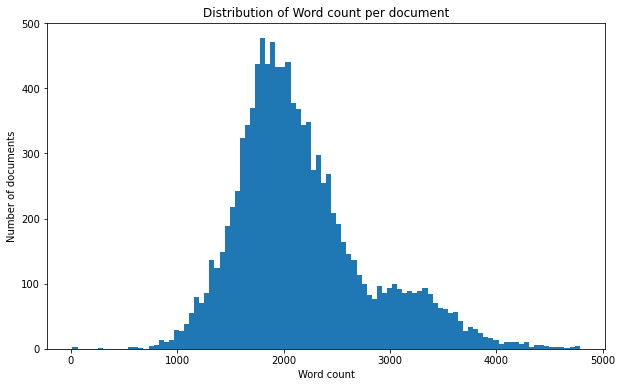

time: 1.79 s (started: 2021-02-21 20:30:43 +00:00)


In [ ]:
import matplotlib.pyplot as plt

words_in_doc = [len(str(d).split(' ')) for d in dt3c['content_10']]
dt3c['wc'] = words_in_doc

plt.figure(figsize=(10,6))
plt.hist(words_in_doc, bins = 100)
plt.title('Distribution of Word count per document')
plt.ylabel('Number of documents')
plt.xlabel('Word count')

In [ ]:
print(f'min: {min(words_in_doc)}')
print(f'max: {max(words_in_doc)}')
wc_lt_900_indexes = dt3c.index[dt3c['wc'] < 900]
print(len(wc_lt_900_indexes))
wc_gt_4500_indexes = dt3c.index[dt3c['wc'] > 4500]
print(len(wc_gt_4500_indexes))

min: 17
max: 4783
35
15
time: 9.96 ms (started: 2021-02-21 20:43:57 +00:00)


In [ ]:
normal_pickle.dump( wc_lt_900_indexes, open( "model/wc_lt_900_indexes.pkl", "wb" ) )
normal_pickle.dump( wc_gt_4500_indexes, open( "model/wc_gt_4500_indexes.pkl", "wb" ) )

time: 22.4 ms (started: 2021-02-21 20:47:26 +00:00)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 10961 entries, 0 to 11010
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   file_path        10961 non-null  object
 1   content_3        10961 non-null  object
 2   content_10       10961 non-null  object
 3   content_3_lang   10961 non-null  object
 4   content_10_lang  10961 non-null  object
 5   title            10961 non-null  object
 6   doi              10961 non-null  object
 7   link             10075 non-null  object
 8   authors          10957 non-null  object
 9   relavent         10961 non-null  object
 10  wc               10961 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 1.0+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10961 entries, 0 to 10960
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   file_path        10961 non-null  object
 1   conten

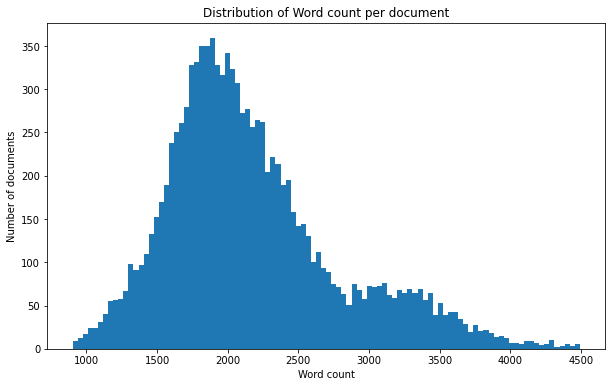

time: 1.72 s (started: 2021-02-21 20:45:44 +00:00)


In [ ]:
ff = dt3c.copy()
ff = ff.drop(wc_lt_900_indexes)
ff = ff.drop(wc_gt_4500_indexes)

ff.info()
ff.reset_index(drop=True, inplace=True)
ff.info()

import matplotlib.pyplot as plt

words_in_doc = [len(str(d).split(' ')) for d in ff['content_10']]
ff['wc'] = words_in_doc

plt.figure(figsize=(10,6))
plt.hist(words_in_doc, bins = 100)
plt.title('Distribution of Word count per document')
plt.ylabel('Number of documents')
plt.xlabel('Word count')

del ff

In [ ]:
dt3c = dt3c.drop(wc_lt_900_indexes)
dt3c = dt3c.drop(wc_gt_4500_indexes)

dt3c.info()
dt3c.reset_index(drop=True, inplace=True)
dt3c.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10961 entries, 0 to 11010
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   file_path        10961 non-null  object
 1   content_3        10961 non-null  object
 2   content_10       10961 non-null  object
 3   content_3_lang   10961 non-null  object
 4   content_10_lang  10961 non-null  object
 5   title            10961 non-null  object
 6   doi              10961 non-null  object
 7   link             10075 non-null  object
 8   authors          10957 non-null  object
 9   relavent         10961 non-null  object
 10  wc               10961 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 1.0+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10961 entries, 0 to 10960
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   file_path        10961 non-null  object
 1   conten

In [ ]:
dt3c.to_pickle('dt3c_normalized.pkl')

time: 1.71 s (started: 2021-02-21 20:46:23 +00:00)


In [ ]:
def get_first_x_words(text, n_words, f):
  arr = re.split('\s+', str(text))
  return ' '.join(arr[:n_words])

time: 3.09 ms (started: 2021-02-21 16:50:21 +00:00)


In [ ]:
dt3c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10961 entries, 0 to 10960
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   file_path        10961 non-null  object 
 1   content_3        10961 non-null  object 
 2   content_10       10961 non-null  object 
 3   content_3_lang   10961 non-null  object 
 4   content_10_lang  10961 non-null  object 
 5   title            10961 non-null  object 
 6   doi              10961 non-null  object 
 7   link             10075 non-null  object 
 8   authors          10957 non-null  object 
 9   relavent         10961 non-null  object 
 10  wc               10961 non-null  int64  
 11  year             10961 non-null  float64
dtypes: float64(1), int64(1), object(10)
memory usage: 1.0+ MB
time: 29.4 ms (started: 2021-02-21 21:29:16 +00:00)


In [ ]:
dt = pickle.load(open('en_cleaned_accounting_replaced_stop_words_lemmatized_all_pages_separetely.pkl', "rb"))# https://drive.google.com/file/d/11ZYfDF9XSXY5bHVhpEHeZXInnNIa9lot/view?usp=sharing
#xx = dt.copy().drop(unknown_lang_indexes)
xx = pd.DataFrame(dt, columns=['file_path', 'page_1'])
del dt
xx.reset_index(drop=True, inplace=True)



non_normalized_indexes = []
yy = dt3c['file_path'].parallel_apply(get_file_name)
for i in range(0, len(xx['file_path'])):
  if not yy.str.match(get_file_name(xx['file_path'][i])).any():
    non_normalized_indexes.append(i)
    
del yy    
xx = xx.drop(non_normalized_indexes)
xx.reset_index(drop=True, inplace=True)
xx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10961 entries, 0 to 10960
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_path  10961 non-null  object
 1   page_1     10961 non-null  object
dtypes: object(2)
memory usage: 171.4+ KB
time: 3min 33s (started: 2021-02-21 20:47:38 +00:00)


In [ ]:
dt3c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10961 entries, 0 to 10960
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   file_path        10961 non-null  object
 1   content_3        10961 non-null  object
 2   content_10       10961 non-null  object
 3   content_3_lang   10961 non-null  object
 4   content_10_lang  10961 non-null  object
 5   title            10961 non-null  object
 6   doi              10961 non-null  object
 7   link             10075 non-null  object
 8   authors          10957 non-null  object
 9   relavent         10961 non-null  object
 10  wc               10961 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 942.1+ KB
time: 398 ms (started: 2021-02-21 21:06:50 +00:00)


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis
import pyLDAvis.sklearn

NUM_OF_TOPICS = 80
NUM_OF_WORDS_IN_EACH_TOPIC = 20
CONTENT_X = 'content_3'

time: 688 ms (started: 2021-02-21 21:07:22 +00:00)


# LDA Topic Modeling (Single Example)

In [ ]:
# LDA Topic Modeling
def topic_modeling(dt3c, stop_list, NUM_OF_TOPICS, NUM_OF_WORDS_IN_EACH_TOPIC, CONTENT_X):
    topic_names = []
    for i in range(NUM_OF_TOPICS):
      topic_names.append("Topic {}".format(i+1))

    count_vectorizer = CountVectorizer(analyzer='word',       
                                min_df=3,                       
                                stop_words=stop_list,             
                                lowercase=True,                   
                                token_pattern='[a-zA-Z0-9]{3,}',  
                                max_features=5000)

    data_vectorized = count_vectorizer.fit_transform(dt3c[CONTENT_X])

    lda_model = LatentDirichletAllocation(n_components=NUM_OF_TOPICS, # Number of topics
                                        learning_method='online',
                                        random_state=0,       
                                        n_jobs = None  # Use all available CPUs
                                        )
    lda_output = lda_model.fit_transform(data_vectorized)

    pyLDAvis.enable_notebook()
    prepareData = pyLDAvis.sklearn.prepare(lda_model, data_vectorized, count_vectorizer, mds='tsne', n_jobs=1)
    pyLDAvis.save_html(prepareData, "results/12_fixed_changed_replaced_"+CONTENT_X+"_topic_"+str(NUM_OF_TOPICS)+"_"+str(NUM_OF_WORDS_IN_EACH_TOPIC)+".html")


    topic_keywords = show_topics(vectorizer=count_vectorizer, lda_model=lda_model, n_words=NUM_OF_WORDS_IN_EACH_TOPIC)
    df_topic_keywords = pd.DataFrame(topic_keywords)
    df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
    df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
    df_topic_keywords['topic_theme'] = topic_names
    df_topic_keywords.set_index('topic_theme', inplace=True)


    ##################################### EXtract TOPICS
    # Create Document - Topic Matrix
    lda_output2 = lda_model.transform(data_vectorized)

    # column names
    topicnames = df_topic_keywords.T.columns

    # index names
    docnames = ["Doc" + str(i) for i in range(len(dt3c))]

    # Make the pandas dataframe
    df_document_topic = pd.DataFrame(np.round(lda_output2, 2), columns=topicnames, index=docnames)

    # Get dominant topic for each document
    dominant_topic = np.argmax(df_document_topic.values, axis=1)
    df_document_topic['dominant_topic'] = dominant_topic

    df_document_topic.reset_index(inplace=True)
    df_sent_topic= pd.merge(dt3c, df_document_topic, left_index=True, right_index=True)
    df_sent_topic.drop('index', axis=1, inplace=True)

    df_topic_theme = df_sent_topic[['file_path', 'dominant_topic']]        
    df_topic_theme['dominant_topic_theme'] = df_topic_theme['dominant_topic'].apply(label_theme)

    ###################################

    topic_sum = pd.DataFrame(np.sum(lda_output, axis = 1))

    column_names = ['file_path', CONTENT_X] + topic_names + ['sum']

    # Turn our docs_nmf array into a data frame
    doc_topic_df = pd.DataFrame(data = lda_output)

    # Merge all of our article metadata and name columns
    doc_topic_df = pd.concat([dt3c[['file_path', CONTENT_X]], 
                            doc_topic_df, topic_sum], axis = 1)
    doc_topic_df.columns = column_names

    # Remove articles with topic sum = 0, then drop sum column
    doc_topic_df = doc_topic_df[doc_topic_df['sum'] != 0]
    doc_topic_df.drop(columns = 'sum', inplace = True)

    # Reset index then save
    doc_topic_df.reset_index(drop = True, inplace = True)
    #doc_topic_df.to_pickle('counter_vectorizer_LDA_8topics_stemmed.pkl')

    topic_array = np.array(doc_topic_df[topic_names])
    norms = np.linalg.norm(topic_array, axis = 1)

    ###################################
    directory_name = "models/model_12_"+CONTENT_X+"_topic_"+str(NUM_OF_TOPICS)+"_"+str(NUM_OF_WORDS_IN_EACH_TOPIC)
    os.makedirs(os.path.dirname(directory_name+"/x.txt"), exist_ok=True)

    normal_pickle.dump( norms, open( directory_name+"/model__norms.pkl", "wb" ) )
    normal_pickle.dump( topic_array, open( directory_name+"/model__topic_array.pkl", "wb" ) )
    normal_pickle.dump(df_topic_keywords, open( directory_name+"/model__df_topic_keywords.pkl", "wb" ))
    normal_pickle.dump( doc_topic_df, open( directory_name+"/model__doc_topic_df.pkl", "wb" ) )
    normal_pickle.dump( lda_model, open( directory_name+"/model__lda_model.pkl", "wb" ) )
    normal_pickle.dump( count_vectorizer, open( directory_name+"/model__count_vectorizer.pkl", "wb" ) )
    normal_pickle.dump( stop_list, open( directory_name+"/model__stop_list.pkl", "wb" ) )
    ###################################

    x = dt3c.copy()
    # Paper Name, Author Name(s), Year and Journal
    ''' THESE CALUES ADDED IN DT3C BEFORE
    x['date'] = x['date'].fillna(0)
    doc_topic_df['year'] = x['date']


    x['Author'] = x['Author'].fillna('-')
    x['authors'] = x['Author'].apply(combine_authors)
    doc_topic_df['authors'] = x['authors']


    x['title'] = x['title'].fillna('-')
    doc_topic_df['title'] = x['title']
    '''

    doc_topic_df['journal'] = x['file_path'].apply(journal_name)

    del x

    normal_pickle.dump( doc_topic_df, open( directory_name+"/model__doc_topic_df.pkl", "wb" ) )

    return lda_model, count_vectorizer, df_topic_keywords, topic_array, doc_topic_df, norms

time: 129 ms (started: 2021-02-21 21:34:09 +00:00)


In [ ]:
#Tried NUM_OF_TOPICS = 30, 70
#Try 
#NUM_OF_TOPICS=60
#CONTENT_X='content_3'
lda_model, count_vectorizer, df_topic_keywords, topic_array, doc_topic_df, norms = topic_modeling(dt3c, stop_list, 60, 20, 'content_3')

top_n = [1, 5, 10, 20, 50, 100]
col_acc_n = ['acc_top_'+str(n) for n in top_n]
xx[col_acc_n] = xx.parallel_apply(lambda x: accuracy_n(x['file_path'], x['page_1'], lda_model, count_vectorizer, df_topic_keywords, topic_array, doc_topic_df, norms, top_n), axis=1)
xx.info()
for n in top_n:
  print('Top-'+str(n)+' Score:' + str(xx['acc_top_'+str(n)].sum()/xx['acc_top_'+str(n)].count()))

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['002', 'ain', 'aren', 'bosnia', 'common', 'couldn', 'dist', 'female', 'genealogy', 'gov', 'hadn', 'hasn', 'herzegovina', 'http', 'isn', 'list', 'male', 'names', 'nomm', 'org', 'shouldn', 'taient', 'tat', 'tions', 'tre', 'wasn', 'weren', 'wiki', 'wikipedia', 'wouldn', 'www'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15149 entries, 0 to 15148
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   file_path    15149 non-null  object
 1   page_1       15149 non-null  object
 2   acc_top_1    15149 non-null  int64 
 3   acc_top_5    15149 non-null  int64 
 4   acc_top_10   15149 non-null  int64 
 5   acc_top_20   15149 non-null  int64 
 6   acc_top_50   15149 non-null  int64 
 7   acc_top_100  15149 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 946.9+ KB
Top-1 Score:0.5543600237639448
Top-5 Score:0.741303056307347
Top-10 Score:0.80698395933725
Top-20 Score:0.8559640900389465
Top-50 Score:0.9079147138424979
Top-100 Score:0.9388738530596079
time: 30min 14s (started: 2021-02-15 08:19:24 +00:00)


In [ ]:
#Try 
#NUM_OF_TOPICS=60
#CONTENT_X='content_10'
lda_model, count_vectorizer, df_topic_keywords, topic_array, doc_topic_df, norms = topic_modeling(dt3c, stop_list, 60, 20, 'content_10')

top_n = [1, 5, 10, 20, 50, 100]
col_acc_n = ['acc_top_'+str(n) for n in top_n]
xx[col_acc_n] = xx.parallel_apply(lambda x: accuracy_n(x['file_path'], x['page_1'], lda_model, count_vectorizer, df_topic_keywords, topic_array, doc_topic_df, norms, top_n), axis=1)
xx.info()
for n in top_n:
  print('Top-'+str(n)+' Score:' + str(xx['acc_top_'+str(n)].sum()/xx['acc_top_'+str(n)].count()))

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['002', 'ain', 'aren', 'bosnia', 'common', 'couldn', 'dist', 'female', 'genealogy', 'gov', 'hadn', 'hasn', 'herzegovina', 'http', 'isn', 'list', 'male', 'names', 'nomm', 'org', 'shouldn', 'taient', 'tat', 'tions', 'tre', 'wasn', 'weren', 'wiki', 'wikipedia', 'wouldn', 'www'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15149 entries, 0 to 15148
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   file_path    15149 non-null  object
 1   page_1       15149 non-null  object
 2   acc_top_1    15149 non-null  int64 
 3   acc_top_5    15149 non-null  int64 
 4   acc_top_10   15149 non-null  int64 
 5   acc_top_20   15149 non-null  int64 
 6   acc_top_50   15149 non-null  int64 
 7   acc_top_100  15149 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 946.9+ KB
Top-1 Score:0.33711796158162255
Top-5 Score:0.5362730213215394
Top-10 Score:0.6207670473298568
Top-20 Score:0.7010363720377583
Top-50 Score:0.7958941184236583
Top-100 Score:0.8592646379298964
time: 38min 36s (started: 2021-02-15 08:49:38 +00:00)


In [ ]:
#Try 
#NUM_OF_TOPICS=50
#CONTENT_X='content_3'
lda_model, count_vectorizer, df_topic_keywords, topic_array, doc_topic_df, norms = topic_modeling(dt3c, stop_list, 50, 20, 'content_3')

top_n = [1, 5, 10, 20, 50, 100]
col_acc_n = ['acc_top_'+str(n) for n in top_n]
xx[col_acc_n] = xx.parallel_apply(lambda x: accuracy_n(x['file_path'], x['page_1'], lda_model, count_vectorizer, df_topic_keywords, topic_array, doc_topic_df, norms, top_n), axis=1)
xx.info()
for n in top_n:
  print('Top-'+str(n)+' Score:' + str(xx['acc_top_'+str(n)].sum()/xx['acc_top_'+str(n)].count()))

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['002', 'ain', 'aren', 'bosnia', 'common', 'couldn', 'dist', 'female', 'genealogy', 'gov', 'hadn', 'hasn', 'herzegovina', 'http', 'isn', 'list', 'male', 'names', 'nomm', 'org', 'shouldn', 'taient', 'tat', 'tions', 'tre', 'wasn', 'weren', 'wiki', 'wikipedia', 'wouldn', 'www'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15149 entries, 0 to 15148
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   file_path    15149 non-null  object
 1   page_1       15149 non-null  object
 2   acc_top_1    15149 non-null  int64 
 3   acc_top_5    15149 non-null  int64 
 4   acc_top_10   15149 non-null  int64 
 5   acc_top_20   15149 non-null  int64 
 6   acc_top_50   15149 non-null  int64 
 7   acc_top_100  15149 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 946.9+ KB
Top-1 Score:0.5108588025612252
Top-5 Score:0.7139745197702818
Top-10 Score:0.7793253680110899
Top-20 Score:0.838471186216912
Top-50 Score:0.8988712126212951
Top-100 Score:0.9321407353620701
time: 29min 20s (started: 2021-02-15 09:28:15 +00:00)


In [ ]:
#Try 
#NUM_OF_TOPICS=50
#CONTENT_X='content_10'
lda_model, count_vectorizer, df_topic_keywords, topic_array, doc_topic_df, norms = topic_modeling(dt3c, stop_list, 50, 20, 'content_10')

top_n = [1, 5, 10, 20, 50, 100]
col_acc_n = ['acc_top_'+str(n) for n in top_n]
xx[col_acc_n] = xx.parallel_apply(lambda x: accuracy_n(x['file_path'], x['page_1'], lda_model, count_vectorizer, df_topic_keywords, topic_array, doc_topic_df, norms, top_n), axis=1)
xx.info()
for n in top_n:
  print('Top-'+str(n)+' Score:' + str(xx['acc_top_'+str(n)].sum()/xx['acc_top_'+str(n)].count()))

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['002', 'ain', 'aren', 'bosnia', 'common', 'couldn', 'dist', 'female', 'genealogy', 'gov', 'hadn', 'hasn', 'herzegovina', 'http', 'isn', 'list', 'male', 'names', 'nomm', 'org', 'shouldn', 'taient', 'tat', 'tions', 'tre', 'wasn', 'weren', 'wiki', 'wikipedia', 'wouldn', 'www'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15149 entries, 0 to 15148
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   file_path    15149 non-null  object
 1   page_1       15149 non-null  object
 2   acc_top_1    15149 non-null  int64 
 3   acc_top_5    15149 non-null  int64 
 4   acc_top_10   15149 non-null  int64 
 5   acc_top_20   15149 non-null  int64 
 6   acc_top_50   15149 non-null  int64 
 7   acc_top_100  15149 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 946.9+ KB
Top-1 Score:0.2924285431381609
Top-5 Score:0.4997029506898145
Top-10 Score:0.5875635355469008
Top-20 Score:0.6737078355006931
Top-50 Score:0.7811736748300218
Top-100 Score:0.8475146874381148
time: 36min 45s (started: 2021-02-15 09:57:35 +00:00)


In [ ]:
#Try 
#NUM_OF_TOPICS=40
#CONTENT_X='content_3'
lda_model, count_vectorizer, df_topic_keywords, topic_array, doc_topic_df, norms = topic_modeling(dt3c, stop_list, 40, 20, 'content_3')

top_n = [1, 5, 10, 20, 50, 100]
col_acc_n = ['acc_top_'+str(n) for n in top_n]
xx[col_acc_n] = xx.parallel_apply(lambda x: accuracy_n(x['file_path'], x['page_1'], lda_model, count_vectorizer, df_topic_keywords, topic_array, doc_topic_df, norms, top_n), axis=1)
xx.info()
for n in top_n:
  print('Top-'+str(n)+' Score:' + str(xx['acc_top_'+str(n)].sum()/xx['acc_top_'+str(n)].count()))

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['002', 'ain', 'aren', 'bosnia', 'common', 'couldn', 'dist', 'female', 'genealogy', 'gov', 'hadn', 'hasn', 'herzegovina', 'http', 'isn', 'list', 'male', 'names', 'nomm', 'org', 'shouldn', 'taient', 'tat', 'tions', 'tre', 'wasn', 'weren', 'wiki', 'wikipedia', 'wouldn', 'www'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15149 entries, 0 to 15148
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   file_path    15149 non-null  object
 1   page_1       15149 non-null  object
 2   acc_top_1    15149 non-null  int64 
 3   acc_top_5    15149 non-null  int64 
 4   acc_top_10   15149 non-null  int64 
 5   acc_top_20   15149 non-null  int64 
 6   acc_top_50   15149 non-null  int64 
 7   acc_top_100  15149 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 946.9+ KB
Top-1 Score:0.44306554888111427
Top-5 Score:0.6583932932866856
Top-10 Score:0.7313354016766783
Top-20 Score:0.7987986005676943
Top-50 Score:0.8700244240543931
Top-100 Score:0.9149778863291307
time: 28min 7s (started: 2021-02-15 10:34:21 +00:00)


In [ ]:
#Try 
#NUM_OF_TOPICS=40
#CONTENT_X='content_10'
lda_model, count_vectorizer, df_topic_keywords, topic_array, doc_topic_df, norms = topic_modeling(dt3c, stop_list, 40, 20, 'content_10')

top_n = [1, 5, 10, 20, 50, 100]
col_acc_n = ['acc_top_'+str(n) for n in top_n]
xx[col_acc_n] = xx.parallel_apply(lambda x: accuracy_n(x['file_path'], x['page_1'], lda_model, count_vectorizer, df_topic_keywords, topic_array, doc_topic_df, norms, top_n), axis=1)
xx.info()
for n in top_n:
  print('Top-'+str(n)+' Score:' + str(xx['acc_top_'+str(n)].sum()/xx['acc_top_'+str(n)].count()))

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['002', 'ain', 'aren', 'bosnia', 'common', 'couldn', 'dist', 'female', 'genealogy', 'gov', 'hadn', 'hasn', 'herzegovina', 'http', 'isn', 'list', 'male', 'names', 'nomm', 'org', 'shouldn', 'taient', 'tat', 'tions', 'tre', 'wasn', 'weren', 'wiki', 'wikipedia', 'wouldn', 'www'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15149 entries, 0 to 15148
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   file_path    15149 non-null  object
 1   page_1       15149 non-null  object
 2   acc_top_1    15149 non-null  int64 
 3   acc_top_5    15149 non-null  int64 
 4   acc_top_10   15149 non-null  int64 
 5   acc_top_20   15149 non-null  int64 
 6   acc_top_50   15149 non-null  int64 
 7   acc_top_100  15149 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 946.9+ KB
Top-1 Score:0.25361409994059014
Top-5 Score:0.44960063370519504
Top-10 Score:0.5334345501353225
Top-20 Score:0.6202389596673048
Top-50 Score:0.7342398838207143
Top-100 Score:0.8148392633177107
time: 33min 34s (started: 2021-02-15 11:36:51 +00:00)


In [ ]:
#Try 
#NUM_OF_TOPICS=80
#CONTENT_X='content_3'
lda_model, count_vectorizer, df_topic_keywords, topic_array, doc_topic_df, norms = topic_modeling(dt3c, stop_list, 80, 20, 'content_3')

top_n = [1, 5, 10, 20, 50, 100]
col_acc_n = ['acc_top_'+str(n) for n in top_n]
xx[col_acc_n] = xx.parallel_apply(lambda x: accuracy_n(x['file_path'], x['page_1'], lda_model, count_vectorizer, df_topic_keywords, topic_array, doc_topic_df, norms, top_n), axis=1)
xx.info()
for n in top_n:
  print('Top-'+str(n)+' Score:' + str(xx['acc_top_'+str(n)].sum()/xx['acc_top_'+str(n)].count()))

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['002', 'ain', 'aren', 'bosnia', 'common', 'couldn', 'dist', 'female', 'genealogy', 'gov', 'hadn', 'hasn', 'herzegovina', 'http', 'isn', 'list', 'male', 'names', 'nomm', 'org', 'shouldn', 'taient', 'tat', 'tions', 'tre', 'wasn', 'weren', 'wiki', 'wikipedia', 'wouldn', 'www'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15149 entries, 0 to 15148
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   file_path    15149 non-null  object
 1   page_1       15149 non-null  object
 2   acc_top_1    15149 non-null  int64 
 3   acc_top_5    15149 non-null  int64 
 4   acc_top_10   15149 non-null  int64 
 5   acc_top_20   15149 non-null  int64 
 6   acc_top_50   15149 non-null  int64 
 7   acc_top_100  15149 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 946.9+ KB
Top-1 Score:0.6117895570664731
Top-5 Score:0.7970163047065812
Top-10 Score:0.8466565449864678
Top-20 Score:0.8908838867251964
Top-50 Score:0.9309525381213282
Top-100 Score:0.9539903624001584
time: 30min 50s (started: 2021-02-15 12:49:37 +00:00)


In [ ]:
#Try 
#NUM_OF_TOPICS=80
#CONTENT_X='content_10'
lda_model, count_vectorizer, df_topic_keywords, topic_array, doc_topic_df, norms = topic_modeling(dt3c, stop_list, 80, 20, 'content_10')

top_n = [1, 5, 10, 20, 50, 100]
col_acc_n = ['acc_top_'+str(n) for n in top_n]
xx[col_acc_n] = xx.parallel_apply(lambda x: accuracy_n(x['file_path'], x['page_1'], lda_model, count_vectorizer, df_topic_keywords, topic_array, doc_topic_df, norms, top_n), axis=1)
xx.info()
for n in top_n:
  print('Top-'+str(n)+' Score:' + str(xx['acc_top_'+str(n)].sum()/xx['acc_top_'+str(n)].count()))

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['002', 'ain', 'aren', 'bosnia', 'common', 'couldn', 'dist', 'female', 'genealogy', 'gov', 'hadn', 'hasn', 'herzegovina', 'http', 'isn', 'list', 'male', 'names', 'nomm', 'org', 'shouldn', 'taient', 'tat', 'tions', 'tre', 'wasn', 'weren', 'wiki', 'wikipedia', 'wouldn', 'www'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15149 entries, 0 to 15148
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   file_path    15149 non-null  object
 1   page_1       15149 non-null  object
 2   acc_top_1    15149 non-null  int64 
 3   acc_top_5    15149 non-null  int64 
 4   acc_top_10   15149 non-null  int64 
 5   acc_top_20   15149 non-null  int64 
 6   acc_top_50   15149 non-null  int64 
 7   acc_top_100  15149 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 946.9+ KB
Top-1 Score:0.38603208132550004
Top-5 Score:0.5865073602217968
Top-10 Score:0.6645983233216713
Top-20 Score:0.7385305960789491
Top-50 Score:0.8238167535810944
Top-100 Score:0.8766255198362928
time: 40min 12s (started: 2021-02-15 13:31:59 +00:00)


In [ ]:
#Try 
#NUM_OF_TOPICS=90
#CONTENT_X='content_3'
lda_model, count_vectorizer, df_topic_keywords, topic_array, doc_topic_df, norms = topic_modeling(dt3c, stop_list, 90, 20, 'content_3')

top_n = [1, 5, 10, 20, 50, 100]
col_acc_n = ['acc_top_'+str(n) for n in top_n]
xx[col_acc_n] = xx.parallel_apply(lambda x: accuracy_n(x['file_path'], x['page_1'], lda_model, count_vectorizer, df_topic_keywords, topic_array, doc_topic_df, norms, top_n), axis=1)
xx.info()
for n in top_n:
  print('Top-'+str(n)+' Score:' + str(xx['acc_top_'+str(n)].sum()/xx['acc_top_'+str(n)].count()))

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['002', 'ain', 'aren', 'bosnia', 'common', 'couldn', 'dist', 'female', 'genealogy', 'gov', 'hadn', 'hasn', 'herzegovina', 'http', 'isn', 'list', 'male', 'names', 'nomm', 'org', 'shouldn', 'taient', 'tat', 'tions', 'tre', 'wasn', 'weren', 'wiki', 'wikipedia', 'wouldn', 'www'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15149 entries, 0 to 15148
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   file_path    15149 non-null  object
 1   page_1       15149 non-null  object
 2   acc_top_1    15149 non-null  int64 
 3   acc_top_5    15149 non-null  int64 
 4   acc_top_10   15149 non-null  int64 
 5   acc_top_20   15149 non-null  int64 
 6   acc_top_50   15149 non-null  int64 
 7   acc_top_100  15149 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 946.9+ KB
Top-1 Score:0.5955508614429995
Top-5 Score:0.773318370849561
Top-10 Score:0.8292296521222523
Top-20 Score:0.8762294540893788
Top-50 Score:0.9208528615750214
Top-100 Score:0.9456069707571457
time: 32min 22s (started: 2021-02-15 14:12:12 +00:00)


In [ ]:
#Try 
#NUM_OF_TOPICS=90
#CONTENT_X='content_10'
lda_model, count_vectorizer, df_topic_keywords, topic_array, doc_topic_df, norms = topic_modeling(dt3c, stop_list, 90, 20, 'content_10')

top_n = [1, 5, 10, 20, 50, 100]
col_acc_n = ['acc_top_'+str(n) for n in top_n]
xx[col_acc_n] = xx.parallel_apply(lambda x: accuracy_n(x['file_path'], x['page_1'], lda_model, count_vectorizer, df_topic_keywords, topic_array, doc_topic_df, norms, top_n), axis=1)
xx.info()
for n in top_n:
  print('Top-'+str(n)+' Score:' + str(xx['acc_top_'+str(n)].sum()/xx['acc_top_'+str(n)].count()))

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['002', 'ain', 'aren', 'bosnia', 'common', 'couldn', 'dist', 'female', 'genealogy', 'gov', 'hadn', 'hasn', 'herzegovina', 'http', 'isn', 'list', 'male', 'names', 'nomm', 'org', 'shouldn', 'taient', 'tat', 'tions', 'tre', 'wasn', 'weren', 'wiki', 'wikipedia', 'wouldn', 'www'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15149 entries, 0 to 15148
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   file_path    15149 non-null  object
 1   page_1       15149 non-null  object
 2   acc_top_1    15149 non-null  int64 
 3   acc_top_5    15149 non-null  int64 
 4   acc_top_10   15149 non-null  int64 
 5   acc_top_20   15149 non-null  int64 
 6   acc_top_50   15149 non-null  int64 
 7   acc_top_100  15149 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 946.9+ KB
Top-1 Score:0.3938213743481418
Top-5 Score:0.6006337051950624
Top-10 Score:0.678064558716747
Top-20 Score:0.7506766123176447
Top-50 Score:0.8353686711994192
Top-100 Score:0.8829625717869166
time: 43min 13s (started: 2021-02-15 14:44:34 +00:00)


In [ ]:
#Try 
#NUM_OF_TOPICS=100
#CONTENT_X='content_3'
lda_model, count_vectorizer, df_topic_keywords, topic_array, doc_topic_df, norms = topic_modeling(dt3c, stop_list, 100, 20, 'content_3')

top_n = [1, 5, 10, 20, 50, 100]
col_acc_n = ['acc_top_'+str(n) for n in top_n]
xx[col_acc_n] = xx.parallel_apply(lambda x: accuracy_n(x['file_path'], x['page_1'], lda_model, count_vectorizer, df_topic_keywords, topic_array, doc_topic_df, norms, top_n), axis=1)
xx.info()
for n in top_n:
  print('Top-'+str(n)+' Score:' + str(xx['acc_top_'+str(n)].sum()/xx['acc_top_'+str(n)].count()))

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['002', 'ain', 'aren', 'bosnia', 'common', 'couldn', 'dist', 'female', 'genealogy', 'gov', 'hadn', 'hasn', 'herzegovina', 'http', 'isn', 'list', 'male', 'names', 'nomm', 'org', 'shouldn', 'taient', 'tat', 'tions', 'tre', 'wasn', 'weren', 'wiki', 'wikipedia', 'wouldn', 'www'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15149 entries, 0 to 15148
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   file_path    15149 non-null  object
 1   page_1       15149 non-null  object
 2   acc_top_1    15149 non-null  int64 
 3   acc_top_5    15149 non-null  int64 
 4   acc_top_10   15149 non-null  int64 
 5   acc_top_20   15149 non-null  int64 
 6   acc_top_50   15149 non-null  int64 
 7   acc_top_100  15149 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 946.9+ KB
Top-1 Score:0.6001716284903293
Top-5 Score:0.7715360749884481
Top-10 Score:0.8229586111294475
Top-20 Score:0.8638193940194072
Top-50 Score:0.9102250973661627
Top-100 Score:0.935969370915572
time: 33min 20s (started: 2021-02-15 15:27:47 +00:00)


In [ ]:
#Try 
#NUM_OF_TOPICS=100
#CONTENT_X='content_10'
lda_model, count_vectorizer, df_topic_keywords, topic_array, doc_topic_df, norms = topic_modeling(dt3c, stop_list, 100, 20, 'content_10')

top_n = [1, 5, 10, 20, 50, 100]
col_acc_n = ['acc_top_'+str(n) for n in top_n]
xx[col_acc_n] = xx.parallel_apply(lambda x: accuracy_n(x['file_path'], x['page_1'], lda_model, count_vectorizer, df_topic_keywords, topic_array, doc_topic_df, norms, top_n), axis=1)
xx.info()
for n in top_n:
  print('Top-'+str(n)+' Score:' + str(xx['acc_top_'+str(n)].sum()/xx['acc_top_'+str(n)].count()))

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['002', 'ain', 'aren', 'bosnia', 'common', 'couldn', 'dist', 'female', 'genealogy', 'gov', 'hadn', 'hasn', 'herzegovina', 'http', 'isn', 'list', 'male', 'names', 'nomm', 'org', 'shouldn', 'taient', 'tat', 'tions', 'tre', 'wasn', 'weren', 'wiki', 'wikipedia', 'wouldn', 'www'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15149 entries, 0 to 15148
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   file_path    15149 non-null  object
 1   page_1       15149 non-null  object
 2   acc_top_1    15149 non-null  int64 
 3   acc_top_5    15149 non-null  int64 
 4   acc_top_10   15149 non-null  int64 
 5   acc_top_20   15149 non-null  int64 
 6   acc_top_50   15149 non-null  int64 
 7   acc_top_100  15149 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 946.9+ KB
Top-1 Score:0.4096640042247013
Top-5 Score:0.6053204832002113
Top-10 Score:0.6788566902105749
Top-20 Score:0.742359231632451
Top-50 Score:0.8226285563403525
Top-100 Score:0.87154267608423
time: 44min 55s (started: 2021-02-15 16:01:07 +00:00)


In [ ]:
#Try 
#NUM_OF_TOPICS=75
#CONTENT_X='content_3'
lda_model, count_vectorizer, df_topic_keywords, topic_array, doc_topic_df, norms = topic_modeling(dt3c, stop_list, 75, 20, 'content_3')

top_n = [1, 5, 10, 20, 50, 100]
col_acc_n = ['acc_top_'+str(n) for n in top_n]
xx[col_acc_n] = xx.parallel_apply(lambda x: accuracy_n(x['file_path'], x['page_1'], lda_model, count_vectorizer, df_topic_keywords, topic_array, doc_topic_df, norms, top_n), axis=1)
xx.info()
for n in top_n:
  print('Top-'+str(n)+' Score:' + str(xx['acc_top_'+str(n)].sum()/xx['acc_top_'+str(n)].count()))

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['002', 'ain', 'aren', 'bosnia', 'common', 'couldn', 'dist', 'female', 'genealogy', 'gov', 'hadn', 'hasn', 'herzegovina', 'http', 'isn', 'list', 'male', 'names', 'nomm', 'org', 'shouldn', 'taient', 'tat', 'tions', 'tre', 'wasn', 'weren', 'wiki', 'wikipedia', 'wouldn', 'www'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15149 entries, 0 to 15148
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   file_path    15149 non-null  object
 1   page_1       15149 non-null  object
 2   acc_top_1    15149 non-null  int64 
 3   acc_top_5    15149 non-null  int64 
 4   acc_top_10   15149 non-null  int64 
 5   acc_top_20   15149 non-null  int64 
 6   acc_top_50   15149 non-null  int64 
 7   acc_top_100  15149 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 946.9+ KB
Top-1 Score:0.5726450590798072
Top-5 Score:0.7541751930820516
Top-10 Score:0.8087002442405439
Top-20 Score:0.8564921777014984
Top-50 Score:0.9084428015050499
Top-100 Score:0.936167403789029
time: 31min 5s (started: 2021-02-15 16:46:07 +00:00)


In [ ]:
#Try 
#NUM_OF_TOPICS=75
#CONTENT_X='content_10'
lda_model, count_vectorizer, df_topic_keywords, topic_array, doc_topic_df, norms = topic_modeling(dt3c, stop_list, 75, 20, 'content_10')

top_n = [1, 5, 10, 20, 50, 100]
col_acc_n = ['acc_top_'+str(n) for n in top_n]
xx[col_acc_n] = xx.parallel_apply(lambda x: accuracy_n(x['file_path'], x['page_1'], lda_model, count_vectorizer, df_topic_keywords, topic_array, doc_topic_df, norms, top_n), axis=1)
xx.info()
for n in top_n:
  print('Top-'+str(n)+' Score:' + str(xx['acc_top_'+str(n)].sum()/xx['acc_top_'+str(n)].count()))

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['002', 'ain', 'aren', 'bosnia', 'common', 'couldn', 'dist', 'female', 'genealogy', 'gov', 'hadn', 'hasn', 'herzegovina', 'http', 'isn', 'list', 'male', 'names', 'nomm', 'org', 'shouldn', 'taient', 'tat', 'tions', 'tre', 'wasn', 'weren', 'wiki', 'wikipedia', 'wouldn', 'www'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15149 entries, 0 to 15148
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   file_path    15149 non-null  object
 1   page_1       15149 non-null  object
 2   acc_top_1    15149 non-null  int64 
 3   acc_top_5    15149 non-null  int64 
 4   acc_top_10   15149 non-null  int64 
 5   acc_top_20   15149 non-null  int64 
 6   acc_top_50   15149 non-null  int64 
 7   acc_top_100  15149 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 946.9+ KB
Top-1 Score:0.36246616938411774
Top-5 Score:0.5598389332629217
Top-10 Score:0.6389200607300812
Top-20 Score:0.7177371443659647
Top-50 Score:0.80434352102449
Top-100 Score:0.8613769885801043
time: 40min 48s (started: 2021-02-15 17:17:13 +00:00)


# ADDITIONAL TEST FOR PROD - model_12_....
with normalized data

In [ ]:
#Try 
#NUM_OF_TOPICS=80
#CONTENT_X='content_3'
lda_model, count_vectorizer, df_topic_keywords, topic_array, doc_topic_df, norms = topic_modeling(dt3c, stop_list, 80, 20, 'content_3')

top_n = [1, 5, 10, 20, 50, 100]
col_acc_n = ['acc_top_'+str(n) for n in top_n]
xx[col_acc_n] = xx.parallel_apply(lambda x: accuracy_n(x['file_path'], x['page_1'], lda_model, count_vectorizer, df_topic_keywords, topic_array, doc_topic_df, norms, top_n), axis=1)
xx.info()
for n in top_n:
  print('Top-'+str(n)+' Score:' + str(xx['acc_top_'+str(n)].sum()/xx['acc_top_'+str(n)].count()))

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['002', 'ain', 'aren', 'bosnia', 'common', 'couldn', 'dist', 'female', 'genealogy', 'gov', 'hadn', 'hasn', 'herzegovina', 'http', 'isn', 'list', 'male', 'names', 'nomm', 'org', 'shouldn', 'taient', 'tat', 'tions', 'tre', 'wasn', 'weren', 'wiki', 'wikipedia', 'wouldn', 'www'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10961 entries, 0 to 10960
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   file_path    10961 non-null  object
 1   page_1       10961 non-null  object
 2   acc_top_1    10961 non-null  int64 
 3   acc_top_5    10961 non-null  int64 
 4   acc_top_10   10961 non-null  int64 
 5   acc_top_20   10961 non-null  int64 
 6   acc_top_50   10961 non-null  int64 
 7   acc_top_100  10961 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 685.2+ KB
Top-1 Score:0.6322415837970988
Top-5 Score:0.8095976644466746
Top-10 Score:0.8606878934403795
Top-20 Score:0.8990967977374327
Top-50 Score:0.9427059574856309
Top-100 Score:0.9690721649484536
time: 20min 6s (started: 2021-02-21 21:34:50 +00:00)


In [ ]:
#Try 
#NUM_OF_TOPICS=80
#CONTENT_X='content_10'
lda_model, count_vectorizer, df_topic_keywords, topic_array, doc_topic_df, norms = topic_modeling(dt3c, stop_list, 80, 20, 'content_10')

top_n = [1, 5, 10, 20, 50, 100]
col_acc_n = ['acc_top_'+str(n) for n in top_n]
xx[col_acc_n] = xx.parallel_apply(lambda x: accuracy_n(x['file_path'], x['page_1'], lda_model, count_vectorizer, df_topic_keywords, topic_array, doc_topic_df, norms, top_n), axis=1)
xx.info()
for n in top_n:
  print('Top-'+str(n)+' Score:' + str(xx['acc_top_'+str(n)].sum()/xx['acc_top_'+str(n)].count()))

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['002', 'ain', 'aren', 'bosnia', 'common', 'couldn', 'dist', 'female', 'genealogy', 'gov', 'hadn', 'hasn', 'herzegovina', 'http', 'isn', 'list', 'male', 'names', 'nomm', 'org', 'shouldn', 'taient', 'tat', 'tions', 'tre', 'wasn', 'weren', 'wiki', 'wikipedia', 'wouldn', 'www'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10961 entries, 0 to 10960
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   file_path    10961 non-null  object
 1   page_1       10961 non-null  object
 2   acc_top_1    10961 non-null  int64 
 3   acc_top_5    10961 non-null  int64 
 4   acc_top_10   10961 non-null  int64 
 5   acc_top_20   10961 non-null  int64 
 6   acc_top_50   10961 non-null  int64 
 7   acc_top_100  10961 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 685.2+ KB
Top-1 Score:0.4140133199525591
Top-5 Score:0.6285010491743455
Top-10 Score:0.7121612991515373
Top-20 Score:0.7876106194690266
Top-50 Score:0.8702673113766992
Top-100 Score:0.9237295867165405
time: 26min 58s (started: 2021-02-21 21:56:03 +00:00)
